In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

In [2]:
df=pd.read_csv('BTCUSDT_1h_20250101_20260101.csv')

In [3]:
df.head()

,OpenTime,Open,High,Low,Close,Volume
0,2025-01-01 00:00,93875.69,94290.91,93712.45,94166.88,462.79342
1,2025-01-01 01:00,94166.88,94222.50,93450.17,93564.04,733.04147
2,2025-01-01 02:00,93564.01,93964.15,93504.67,93899.68,337.52715
3,2025-01-01 03:00,93899.67,93899.67,93375.58,93488.84,315.53272
4,2025-01-01 04:00,93488.83,93756.00,93375.38,93576.00,336.57995


In [8]:
#Ensure datetime
df['OpenTime'] = pd.to_datetime(df['OpenTime'])


Overall Price Path

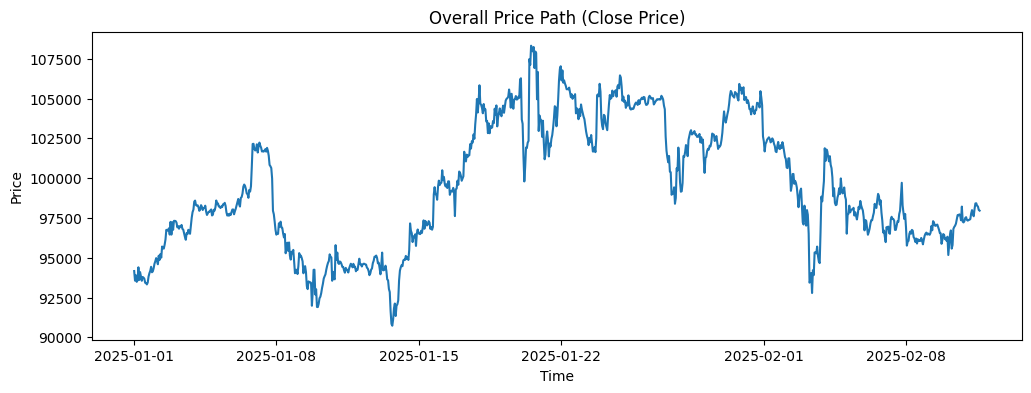

In [9]:
plt.figure(figsize=(12,4))
plt.plot(df['OpenTime'], df['Close'])
plt.title("Overall Price Path (Close Price)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()


Overall Volume Behavior 

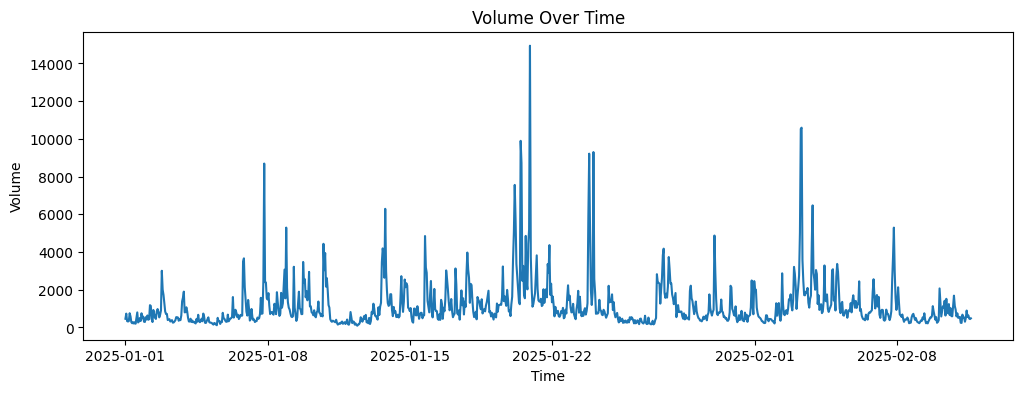

In [10]:
plt.figure(figsize=(12,4))
plt.plot(df['OpenTime'], df['Volume'])
plt.title("Volume Over Time")
plt.xlabel("Time")
plt.ylabel("Volume")
plt.show()


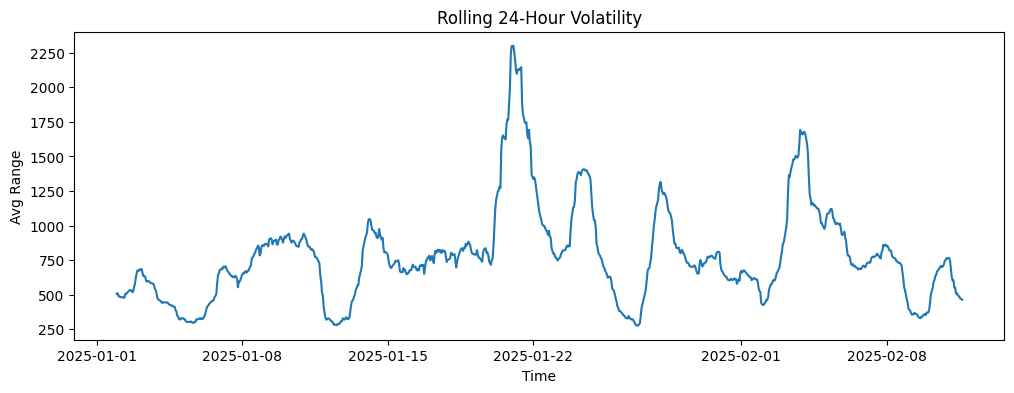

In [12]:
df['RollingVol'] = df['Range'].rolling(24).mean()

plt.figure(figsize=(12,4))
plt.plot(df['OpenTime'], df['RollingVol'])
plt.title("Rolling 24-Hour Volatility")
plt.xlabel("Time")
plt.ylabel("Avg Range")
plt.show()


Summary Metrics

In [13]:
summary = {
    "Avg Price": df['Close'].mean(),
    "Avg Volume": df['Volume'].mean(),
    "Avg Volatility": df['Range'].mean(),
    "Max Volatility": df['Range'].max()
}

summary


{'Avg Price': np.float64(99448.42177),
 'Avg Volume': np.float64(1161.460447032),
 'Avg Volatility': np.float64(774.0624100000001),
 'Max Volatility': np.float64(7367.199999999997)}

In [14]:
kpis = {
    "Average Close": df['Close'].mean(),
    "Maximum High": df['High'].max(),
    "Minimum Low": df['Low'].min(),
    "Average Range (H-L)": (df['High'] - df['Low']).mean()
}

pd.Series(kpis)


Average Close           99448.42177
Maximum High           109588.00000
Minimum Low             89256.69000
Average Range (H-L)       774.06241
dtype: float64

Buying vs Selling Pressure (Market Intent)
Logic

Close > Open → Buying pressure

Close < Open → Selling pressure

In [15]:
df['Pressure'] = df.apply(
    lambda x: 'Buying' if x['Close'] > x['Open'] else 'Selling',
    axis=1
)

pressure_dist = df['Pressure'].value_counts(normalize=True) * 100
pressure_dist


Pressure
Buying     50.3
Selling    49.7
Name: proportion, dtype: float64

Candle Body Size (Move Strength)

In [16]:
df['BodySize'] = abs(df['Close'] - df['Open'])

df[['BodySize']].describe()


,BodySize
count,1000.000000
mean,377.761590
std,440.301678
min,0.020000
25%,111.792500
50%,243.845000
75%,470.860000
max,5142.300000


Volume + Body Confirmation

In [17]:
volume_threshold = df['Volume'].quantile(0.75)
body_threshold = df['BodySize'].quantile(0.75)

df['MoveType'] = df.apply(
    lambda x: 'Institutional'
    if x['Volume'] > volume_threshold and x['BodySize'] > body_threshold
    else 'Retail/Noise',
    axis=1
)

df['MoveType'].value_counts(normalize=True) * 100


MoveType
Retail/Noise     85.3
Institutional    14.7
Name: proportion, dtype: float64

### Day / Hour Aggregated Summary

Hourly Behavior

In [18]:
df['Hour'] = df['OpenTime'].dt.hour

hourly_summary = df.groupby('Hour').agg({
    'Close': 'mean',
    'Volume': 'mean',
    'BodySize': 'mean'
})

hourly_summary.head()


,Close,Volume,BodySize
Hour,,,
0,99638.935000,1189.475544,459.503810
1,99497.986905,1472.597005,445.230476
2,99328.252857,1075.793710,419.689048
3,99433.722619,881.208115,362.875952
4,99336.530476,897.776821,331.679286


Close Price Distribution

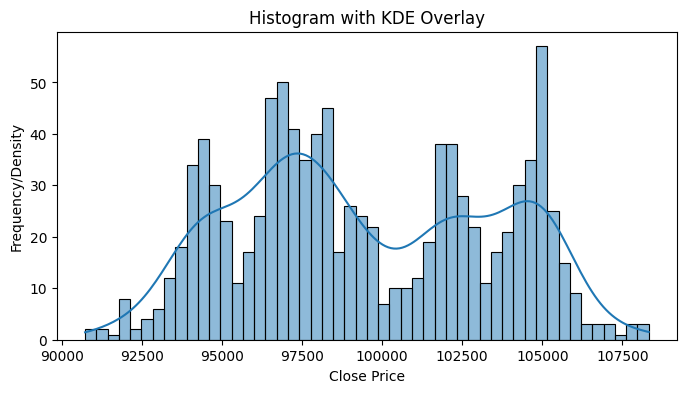

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
# The 'histplot' function can overlay a KDE curve using 'kde=True'
sns.histplot(data=df, x='Close', kde=True, bins=50) 
plt.title('Histogram with KDE Overlay')
plt.xlabel('Close Price')
plt.ylabel('Frequency/Density')
plt.show()


Range (High − Low) Distribution

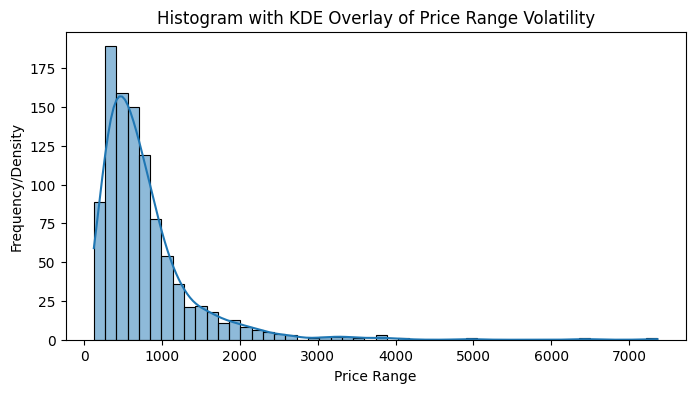

In [33]:
plt.figure(figsize=(8, 4))

# Use seaborn's histplot function and set 'kde=True' to overlay the line
sns.histplot(data=df, x='Range', bins=50, kde=True) 

plt.title('Histogram with KDE Overlay of Price Range Volatility')
plt.xlabel('Price Range')
plt.ylabel('Frequency/Density')
plt.show()


Buying vs Selling Pressure

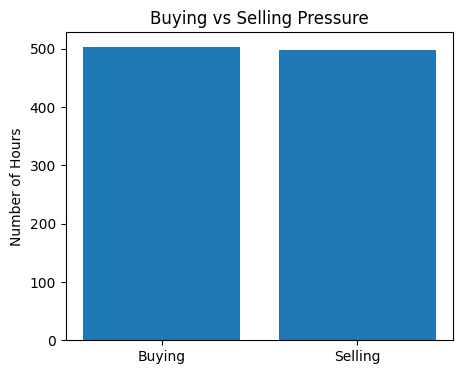

In [38]:
df['Pressure'] = df.apply(
    lambda x: 'Buying' if x['Close'] > x['Open'] else 'Selling',
    axis=1
)

pressure_counts = df['Pressure'].value_counts()

plt.figure(figsize=(5,4))
plt.bar(pressure_counts.index, pressure_counts.values)
plt.title("Buying vs Selling Pressure")
plt.ylabel("Number of Hours")
plt.show()


Candle Body Size — Move Strength

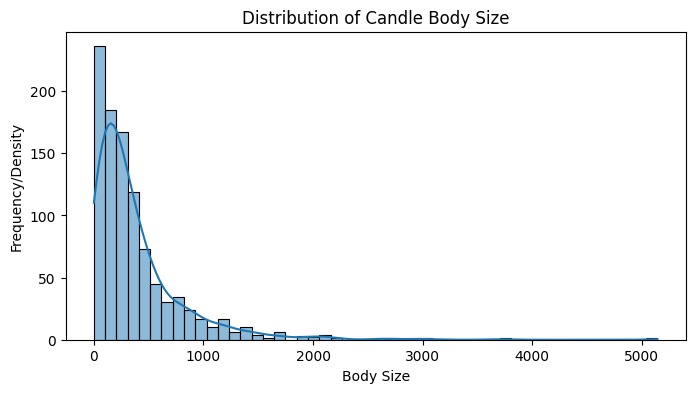

In [47]:

import seaborn as sns

# Assuming 'df' is your DataFrame and 'Close', 'Open' exist
df['BodySize'] = abs(df['Close'] - df['Open'])

plt.figure(figsize=(8, 4))

# CORRECTED LINE: Using 'data=df' and 'x='BodySize'' is the standard seaborn approach
sns.histplot(data=df, x='BodySize', bins=50, kde=True) 

plt.title('Distribution of Candle Body Size')
plt.xlabel('Body Size')
plt.ylabel('Frequency/Density')
plt.show()


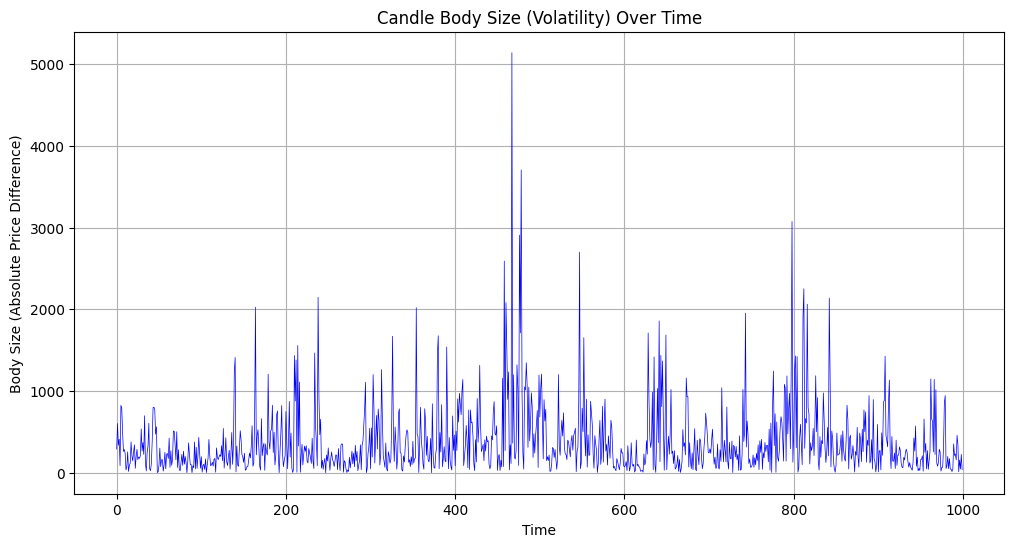

In [48]:
plt.figure(figsize=(12, 6))
# Assuming your DataFrame 'df' has a DatetimeIndex
plt.plot(df.index, df['BodySize'], color='blue', linewidth=0.5)
plt.title('Candle Body Size (Volatility) Over Time')
plt.xlabel('Time')
plt.ylabel('Body Size (Absolute Price Difference)')
plt.grid(True)
plt.show()


Volume Distribution

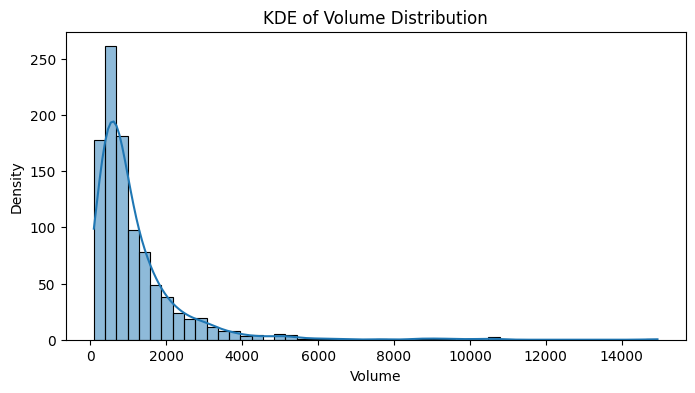

In [52]:
plt.figure(figsize=(8,4))
# Assuming 'df' is your DataFrame and 'Volume' is the column name
sns.histplot(data=df, x='Volume', bins=50, kde=True) 
plt.title('KDE of Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Density') # Y-axis changes from Frequency to Density
plt.show()


Volume vs Body Size — Real vs Fake Moves

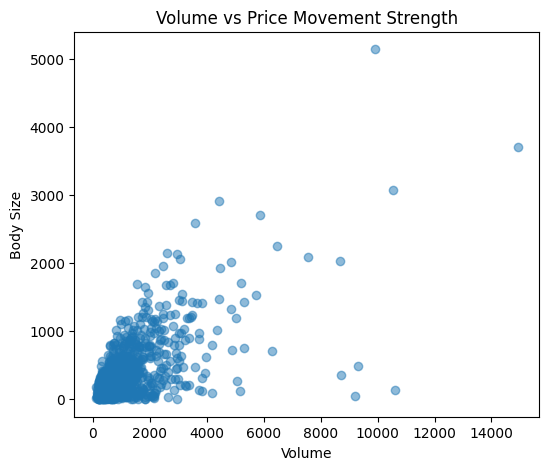

In [53]:
plt.figure(figsize=(6,5))
plt.scatter(df['Volume'], df['BodySize'], alpha=0.5)
plt.xlabel("Volume")
plt.ylabel("Body Size")
plt.title("Volume vs Price Movement Strength")
plt.show()


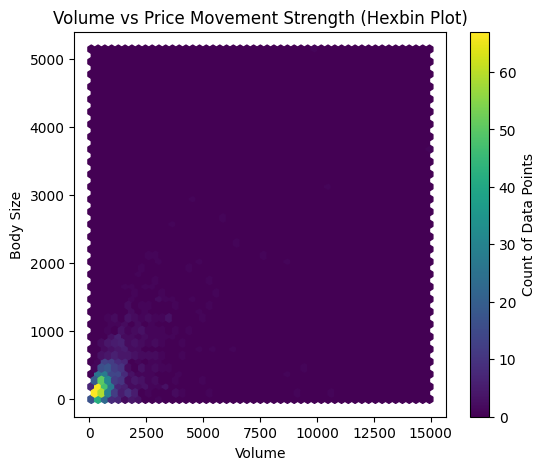

In [55]:

plt.figure(figsize=(6, 5))

# Use the hexbin function instead of scatter
# C is the color map (RdPu is a nice gradient, you can use 'viridis', 'plasma', etc.)
# gridsize controls the resolution of the hexagons
plt.hexbin(df['Volume'], df['BodySize'], gridsize=50, cmap='viridis') 

plt.xlabel("Volume")
plt.ylabel("Body Size")
plt.title("Volume vs Price Movement Strength (Hexbin Plot)")

# Add a color bar to indicate the count/frequency in each hexagon
plt.colorbar(label='Count of Data Points') 

plt.show()


Hourly Descriptive Behavior

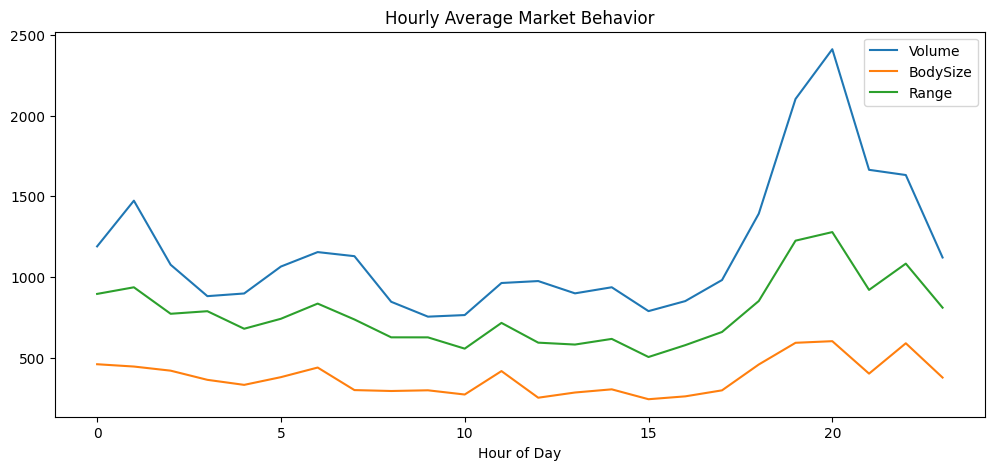

In [54]:
df['Hour'] = df['OpenTime'].dt.hour

hourly_avg = df.groupby('Hour')[['Volume', 'BodySize', 'Range']].mean()

hourly_avg.plot(figsize=(12,5))
plt.title("Hourly Average Market Behavior")
plt.xlabel("Hour of Day")
plt.show()


### Candlestick Behavior

Candle Metrics

In [56]:
# Body size
df['BodySize'] = abs(df['Close'] - df['Open'])

# Upper wick
df['UpperWick'] = df['High'] - df[['Open','Close']].max(axis=1)

# Lower wick
df['LowerWick'] = df[['Open','Close']].min(axis=1) - df['Low']


Candle Type (Bullish / Bearish / Doji)

In [57]:
def candle_type(row):
    if row['Close'] > row['Open']:
        return 'Bullish'
    elif row['Close'] < row['Open']:
        return 'Bearish'
    else:
        return 'Doji'

df['CandleType'] = df.apply(candle_type, axis=1)


Reversal / Trap Detection

In [62]:
# Previous candle info
df['PrevClose'] = df['Close'].shift(1)
df['PrevOpen'] = df['Open'].shift(1)

# Identify potential reversals
def detect_reversal(row):
    if pd.isna(row['PrevClose']):
        return 'Normal'
    # Bullish → Bearish
    if row['PrevClose'] > row['PrevOpen'] and row['Close'] < row['Open']:
        return 'Bearish Reversal'
    # Bearish → Bullish
    elif row['PrevClose'] < row['PrevOpen'] and row['Close'] > row['Open']:
        return 'Bullish Reversal'
    else:
        return 'Normal'

df['PotentialReversal'] = df.apply(detect_reversal, axis=1)


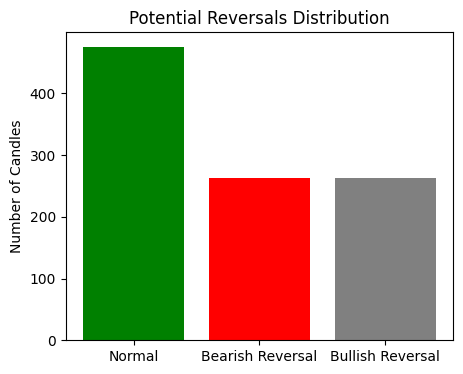

In [66]:
reversal_counts = df['PotentialReversal'].value_counts()

plt.figure(figsize=(5,4))
plt.bar(reversal_counts.index, reversal_counts.values, color=['green','red','grey'])
plt.title("Potential Reversals Distribution")
plt.ylabel("Number of Candles")
plt.show()

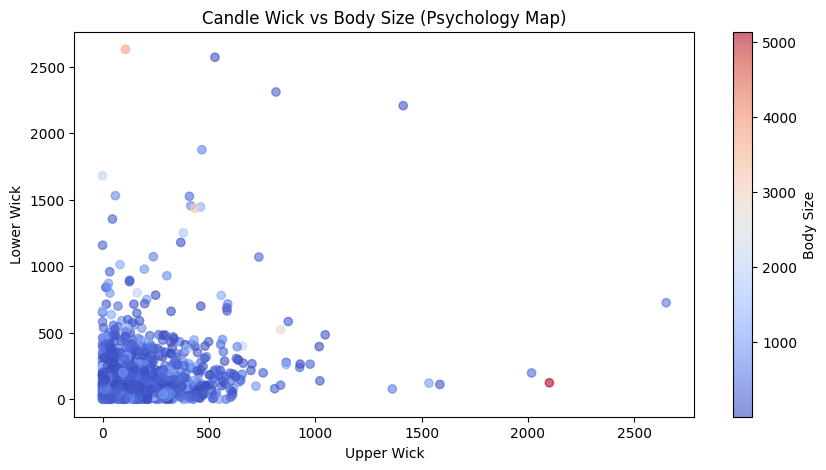

In [67]:
plt.figure(figsize=(10,5))
plt.scatter(df['UpperWick'], df['LowerWick'], c=df['BodySize'], cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Body Size')
plt.xlabel("Upper Wick")
plt.ylabel("Lower Wick")
plt.title("Candle Wick vs Body Size (Psychology Map)")
plt.show()


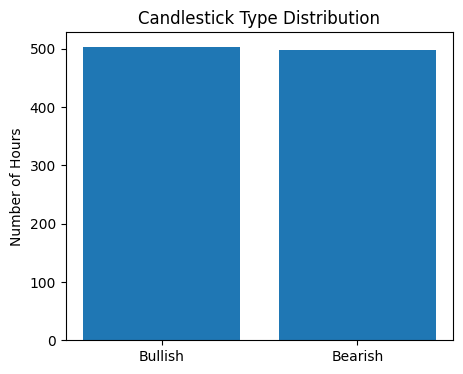

In [68]:
candle_counts = df['CandleType'].value_counts()

plt.figure(figsize=(5,4))
plt.bar(candle_counts.index, candle_counts.values)
plt.title("Candlestick Type Distribution")
plt.ylabel("Number of Hours")
plt.show()


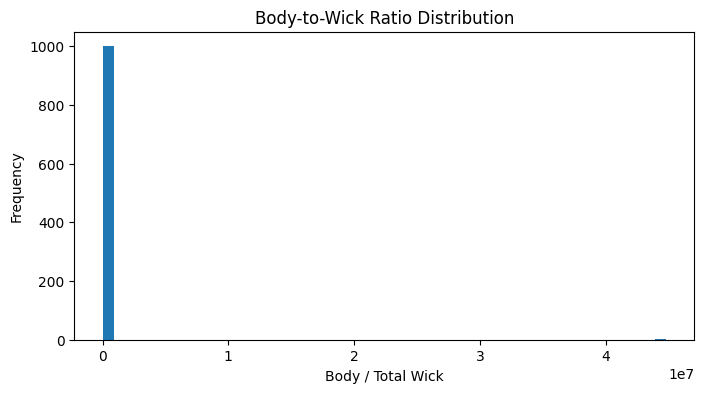

In [69]:
df['BodyWickRatio'] = df['BodySize'] / (df['UpperWick'] + df['LowerWick'] + 1e-5)

plt.figure(figsize=(8,4))
plt.hist(df['BodyWickRatio'], bins=50)
plt.title("Body-to-Wick Ratio Distribution")
plt.xlabel("Body / Total Wick")
plt.ylabel("Frequency")
plt.show()


Volatility Metrics

In [70]:
df['Range'] = df['High'] - df['Low']  # Absolute volatility
df['VolatilityPct'] = df['Range'] / df['Open'] * 100  # Relative %


In [71]:
df['RollingVol3H'] = df['Range'].rolling(3).mean()
df['RollingVol6H'] = df['Range'].rolling(6).mean()
df['RollingVol24H'] = df['Range'].rolling(24).mean()


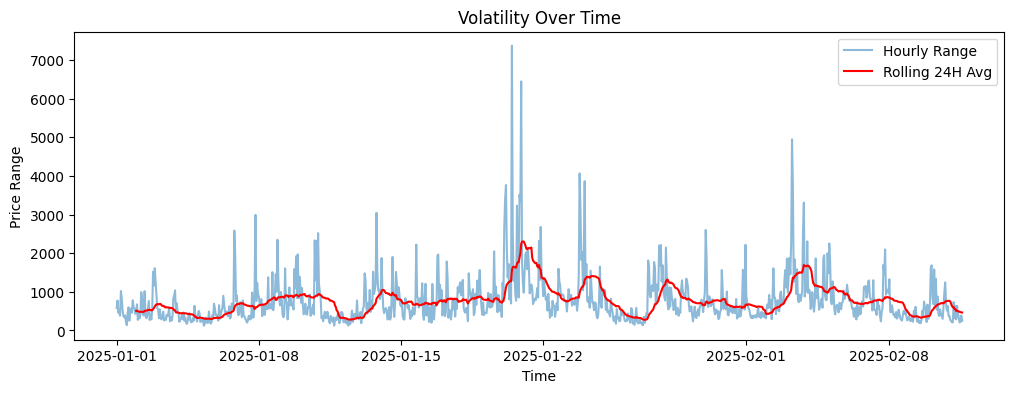

In [72]:
plt.figure(figsize=(12,4))
plt.plot(df['OpenTime'], df['Range'], alpha=0.5, label='Hourly Range')
plt.plot(df['OpenTime'], df['RollingVol24H'], color='red', label='Rolling 24H Avg')
plt.title("Volatility Over Time")
plt.xlabel("Time")
plt.ylabel("Price Range")
plt.legend()
plt.show()


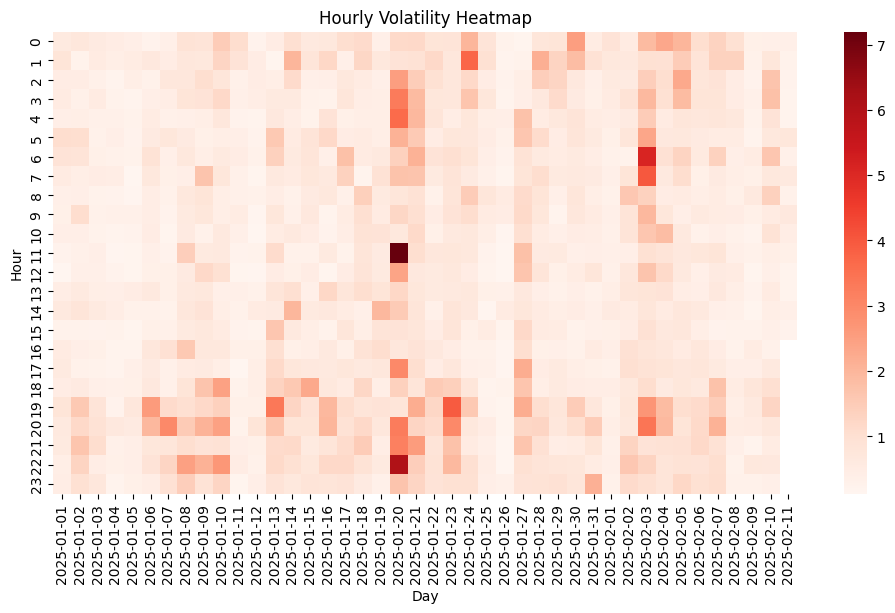

In [73]:
df['Hour'] = df['OpenTime'].dt.hour
df['Day'] = df['OpenTime'].dt.date

heatmap_data = df.pivot_table(index='Hour', columns='Day', values='VolatilityPct', aggfunc='mean')

import seaborn as sns
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap='Reds')
plt.title("Hourly Volatility Heatmap")
plt.show()


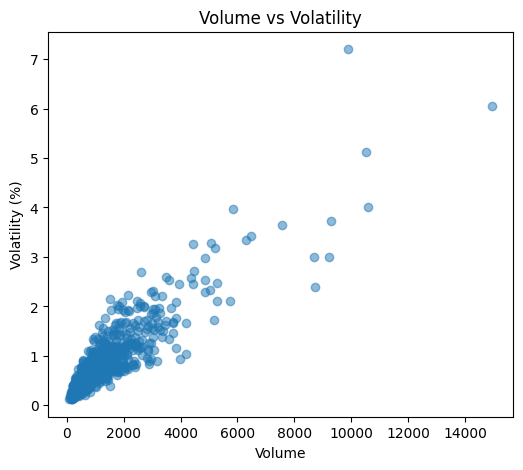

In [74]:
plt.figure(figsize=(6,5))
plt.scatter(df['Volume'], df['VolatilityPct'], alpha=0.5)
plt.xlabel("Volume")
plt.ylabel("Volatility (%)")
plt.title("Volume vs Volatility")
plt.show()


### Time-Based Market Behavior

In [75]:
df['Hour'] = df['OpenTime'].dt.hour
df['DayOfWeek'] = df['OpenTime'].dt.day_name()
df['Month'] = df['OpenTime'].dt.month


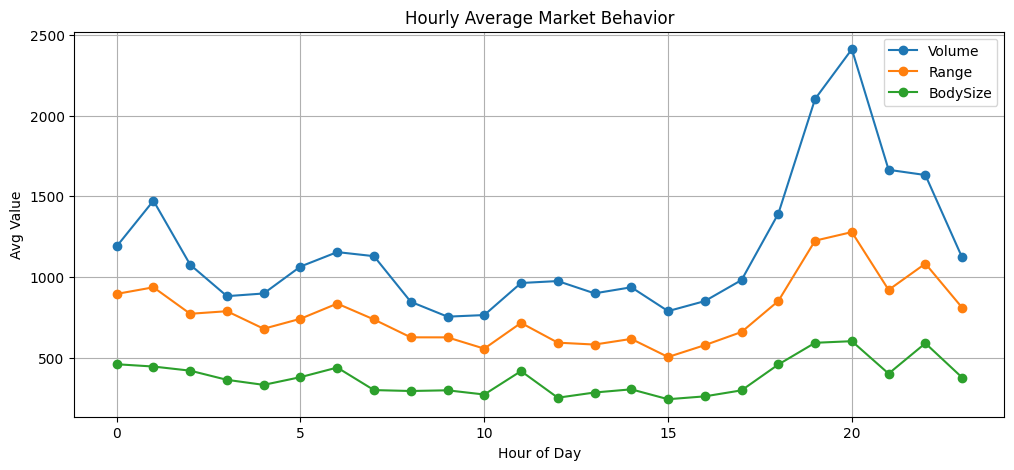

In [76]:
hourly_avg = df.groupby('Hour')[['Volume','Range','BodySize']].mean()

hourly_avg.plot(figsize=(12,5), marker='o')
plt.title("Hourly Average Market Behavior")
plt.xlabel("Hour of Day")
plt.ylabel("Avg Value")
plt.grid(True)
plt.show()


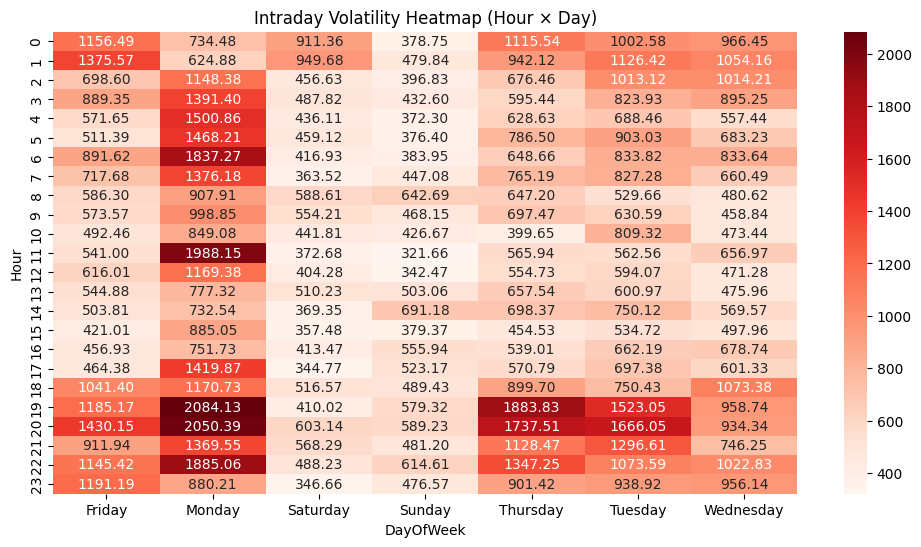

In [77]:
import seaborn as sns

heatmap_data = df.pivot_table(index='Hour', columns='DayOfWeek', values='Range', aggfunc='mean')

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap='Reds', annot=True, fmt=".2f")
plt.title("Intraday Volatility Heatmap (Hour × Day)")
plt.show()


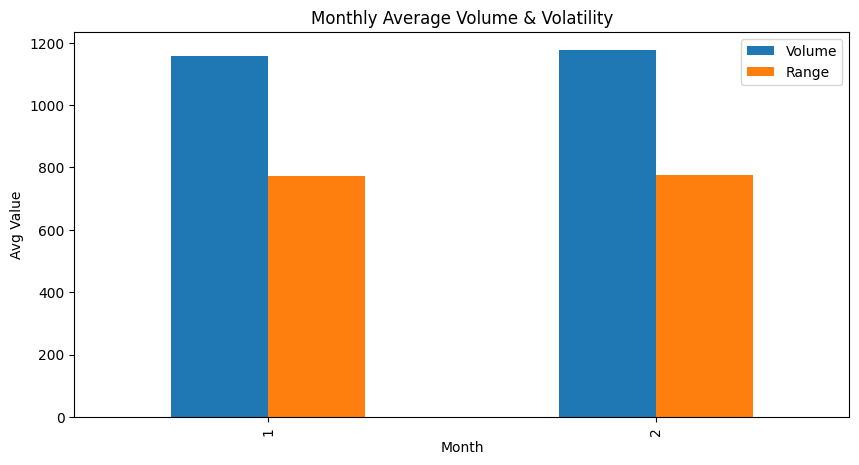

In [78]:
monthly_avg = df.groupby('Month')[['Volume','Range']].mean()

monthly_avg.plot(kind='bar', figsize=(10,5))
plt.title("Monthly Average Volume & Volatility")
plt.xlabel("Month")
plt.ylabel("Avg Value")
plt.show()


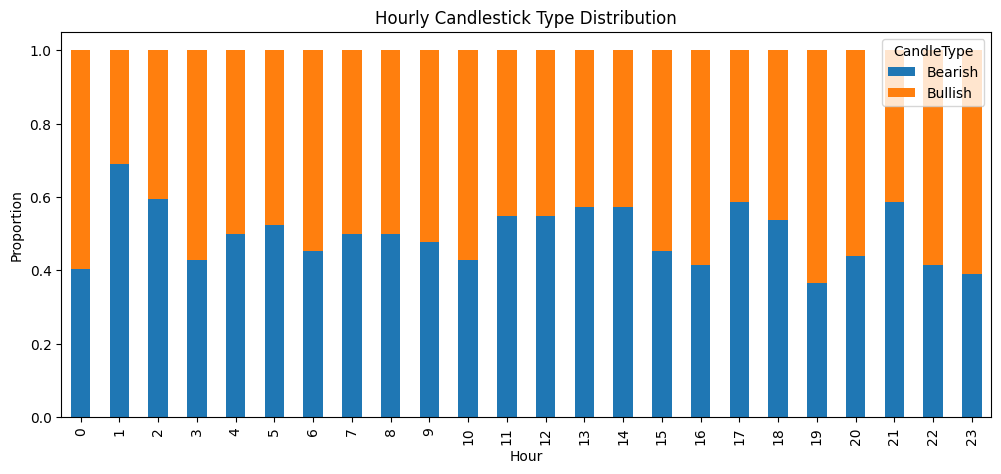

In [79]:
hourly_candle = df.groupby('Hour')['CandleType'].value_counts(normalize=True).unstack().fillna(0)

hourly_candle.plot(kind='bar', stacked=True, figsize=(12,5))
plt.title("Hourly Candlestick Type Distribution")
plt.xlabel("Hour")
plt.ylabel("Proportion")
plt.show()


### Year-Long Regime Detection

In [80]:
# Thresholds
body_thresh = df['BodySize'].quantile(0.75)   # top 25% body = strong move
vol_thresh = df['RollingVol24H'].quantile(0.75)  # top 25% vol = volatile
volume_thresh = df['Volume'].quantile(0.75)  # high liquidity

def classify_regime(row):
    if row['BodySize'] > body_thresh and row['Volume'] > volume_thresh:
        return 'Trending'
    elif row['BodySize'] < body_thresh and row['Volume'] < volume_thresh:
        return 'Ranging'
    elif (row['UpperWick'] > row['BodySize'] or row['LowerWick'] > row['BodySize']) and row['Range'] > vol_thresh:
        return 'High Risk'
    else:
        return 'Ranging'

df['Regime'] = df.apply(classify_regime, axis=1)


Visualize Regime Timeline

C:\Users\92msm\AppData\Local\Programs\Python\Python314\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


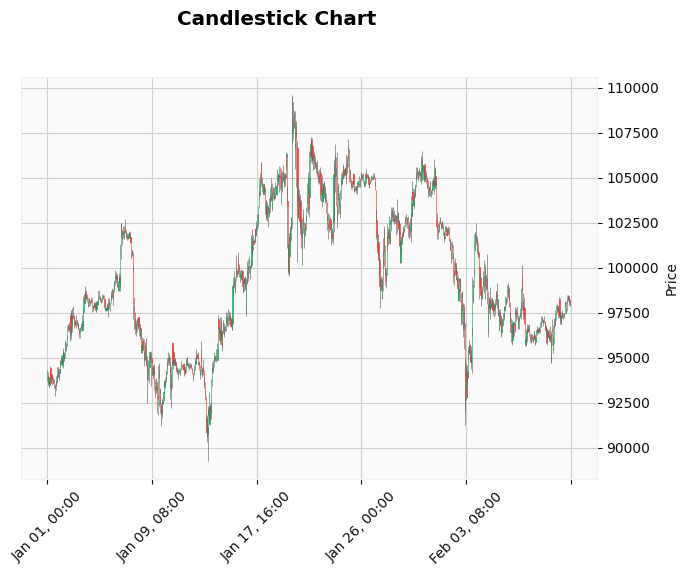

In [82]:
import mplfinance as mpf
import pandas as pd

# Ensure 'OpenTime' is a datetime object and set as the index
df['OpenTime'] = pd.to_datetime(df['OpenTime'])
df = df.set_index('OpenTime')

# The mplfinance plot function looks for columns named 'Open', 'High', 'Low', 'Close'
# You might need to rename your columns if they have different names (e.g., 'Close' is fine)
# Example: df.rename(columns={'YourHighCol': 'High', 'YourLowCol': 'Low', 'YourOpenCol': 'Open'}, inplace=True)

# Generate the candlestick chart
mpf.plot(df, type='candle', style='yahoo', title='Candlestick Chart', ylabel='Price')


In [83]:
regime_stats = df['Regime'].value_counts(normalize=True) * 100
regime_stats


Regime
Ranging      79.8
Trending     14.7
High Risk     5.5
Name: proportion, dtype: float64

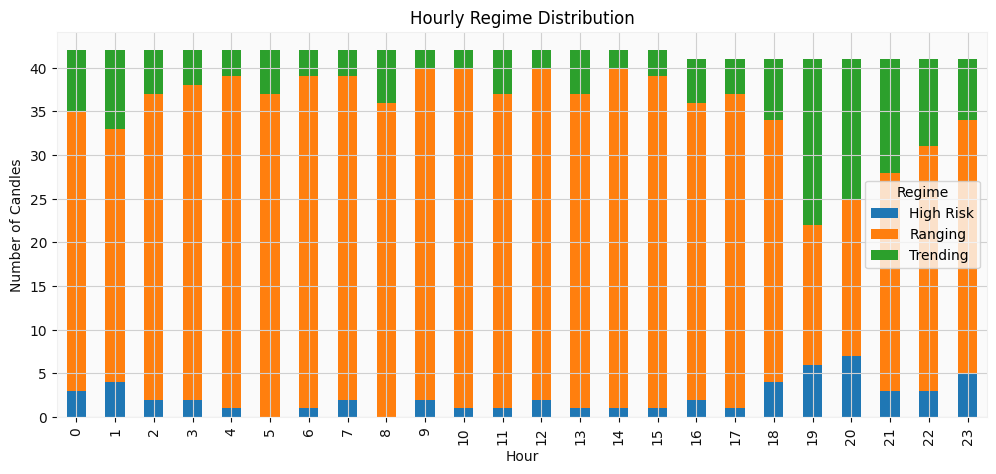

In [84]:
heatmap_data = df.pivot_table(index='Hour', columns='Regime', values='Close', aggfunc='count').fillna(0)

heatmap_data.plot(kind='bar', stacked=True, figsize=(12,5))
plt.title("Hourly Regime Distribution")
plt.xlabel("Hour")
plt.ylabel("Number of Candles")
plt.show()
